In [1]:
import scipy as sp
import scipy.misc as misc
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
data_dir = 'data/'

In [3]:
df_iiw = pd.read_csv(filepath_or_buffer=data_dir + 'data_iiw_complete.csv', sep=',',
                     names=['image_path', 'label_path'])
df_iiw = data_dir + df_iiw
df_iiw_train = pd.read_csv(filepath_or_buffer=data_dir + 'data_iiw_train.csv', sep=',',
                           names=['image_path', 'label_path'])
df_iiw_train = data_dir + df_iiw_train
df_iiw_valid = pd.read_csv(filepath_or_buffer=data_dir + 'data_iiw_valid.csv', sep=',',
                          names=['image_path', 'label_path'])
df_iiw_valid = data_dir + df_iiw_valid
df_iiw_test = pd.read_csv(filepath_or_buffer=data_dir + 'data_iiw_test.csv', sep=',',
                          names=['image_path', 'label_path'])
df_iiw_test = data_dir + df_iiw_test
df_sintel = pd.read_csv(filepath_or_buffer=data_dir + 'data_sintel_shading_complete.csv', sep=',', 
                        names=['image_path', 'label_path'])
df_sintel = data_dir + df_sintel
# df_sintel_test_unknown = pd.read_csv(filepath_or_buffer=data_dir + 'data_sintel_complete_test_unknown.csv', 
#                                      sep=',', names=['image_path', 'label_path'])
# df_sintel_test_unknown['image_path'] = data_dir + df_sintel_test_unknown['image_path']
df_mit = pd.read_csv(filepath_or_buffer=data_dir + 'data_mit_complete.csv', sep=',', 
                     names=['image_path', 'albedo_label_path', 'shading_label_path'])
df_mit = data_dir + df_mit

In [4]:
def df_images_analysis(df, file_path, prefix=''):
    # TODO: if this function crashes it might be if one imports shape of a grayscale
    # image that consists only of (height, widht) information.
    """
    Appends image analysis columns to pd.DataFrame df.
    df must at least contain one column file_path where image paths are saved.
    These images are read and analysed.
    The following columns are appended to DataFrame df:
        'shape', 'height', 'nr_channels', 'aspect_ratio', 'nr_pixels'
    :param df: DataFrame that contains a column with paths to images
    :type df: pd.DataFrame
    :param file_path: column name of the DataFrame where the paths to images are located 
    :type file_path: str
    :param prefix: a (optional) prefix that can be inserted before the new defined column names
    :type prefix: str (default: '')
    :return: DataFrame df with above described appended columns
    """
    # read every file saved in column file_path and get shape:
    df[prefix + 'shape'] = df[file_path].apply(lambda x: sp.misc.imread(x).shape)
    # expand height, width and nr of channels to separate rows
    df[prefix + 'shape'] = df[prefix + 'shape'].apply(lambda x: x + (1,) if len(x)==2 else x)        
    df[[prefix + 'height', prefix + 'width', prefix + 'nr_channels']] = df[prefix + 'shape'].apply(pd.Series)
    # get aspect ratio:
    df[prefix + 'aspect_ratio'] = df[prefix + 'width'] / df[prefix + 'height']
    # get nr of pixels:
    df[prefix + 'nr_pixels'] = df[prefix + 'height'] * df[prefix + 'width'] * df[prefix + 'nr_channels']
    return df

def plot_stats(df, prefix=''):
    fixsize = (15, 4)
    plt.figure(figsize=fixsize)
    plt.hist(df[['image_width', 'image_height']].values, bins=20, log=True, label=['image_width', 'image_height'])
    plt.xlabel("Nr. pixels")
    plt.ylabel("count (log scale)")
    plt.legend(loc='upper left')
    plt.show()
    plt.figure(figsize=fixsize)
    plt.hist(df[['image_width', 'image_height']].values, bins=20, log=False, label=['image_width', 'image_height'])
    plt.xlabel("Nr. pixels")
    plt.ylabel("count")
    plt.legend(loc='upper left')
    plt.show()
    ax = df[[prefix + 'nr_channels']].plot(kind='hist', bins=10, figsize=fixsize, fontsize=12)
    txt = ax.set_xlabel("Nr. channels")
    ax = df[[prefix + 'aspect_ratio']].plot(kind='hist', bins=10, figsize=fixsize, fontsize=12)
    txt = ax.set_xlabel("Aspect ratio (width / height)")
    ax = df[[prefix + 'nr_pixels']].plot(kind='hist', bins=20, figsize=fixsize, fontsize=12)
    txt = ax.set_xlabel("Nr. pixels")

In [5]:
def image_analysis(file_list, conf_int=2, average='mean'):
    """
    Analyses a list of images with respect to their shapes.
    This is necessary to get a preselection of images for shape adjustment in the next steps 
    (because each input to a CNN should have the same shape).
    :param file_list: list of locations of images (list of strings)
    :param conf_int: confidence interval 1 sigma, 2 sigma, ... (int, default: 2)
    :param average: select an average measure: mean or median (default: mean)
    :return: 3 outputs:
        - pd.DataFrame with all images and shapes that have valid shape and size
        - pd.DataFrame with all images that do not have the correct shape (mostly because 
          they only have one channel, -> grayscale image)
        - pd.DataFrame with all images with one shape value outside of the defined confidence interval
    """
    # create a dictionary with entries: key: image name, value: image shape
    d = {}
    for file in file_list:
        # lower-case filenames:
        file = file.lower()
        # only take .jpeg images from directory:
        if file[-5:] == '.jpeg':
            # write shape of each image to dictionary:
            d[file[:-5]] = np.array(plt.imread(image_dir + file).shape)      
    # transform dictionary to pandas DataFrame:
    df = pd.DataFrame.from_dict(d, orient="index")
    df.columns = ['height', 'width', 'channels']
    # Get entries with shape missmatch
    shape_missmatch = df[df.isnull().any(axis=1)]
    # remove miss-matched images, most probably grayscale images with just 1 channel:
    df.drop(shape_missmatch.index, axis=0, inplace=True)
    # only chose those values that lie in the confidence interval conf_int for each dimension:
    if average == 'mean':
        # ... using mean and standard deviation:
        df2 = df[((df >= df.mean() - conf_int * df.std()) & (df <= df.mean() + conf_int * df.std()))]
        # dismissed because values are out of bound:
        dim_missmatch = df[df2.isnull().any(axis=1)]
        df2.drop(dim_missmatch.index, axis=0, inplace=True)
        print('Ratio of remaining image after applying confidence interval: ' + str(df2['width'].count() / df['width'].count()))
    elif average == 'median':
        # ... using median and median absolute deviation
        df2 = df[((df >= df.median() - conf_int * df.mad()) & (df <= df.median() + conf_int * df.mad()))]
        # dismissed because values are out of bound:
        dim_missmatch = df[df2.isnull().any(axis=1)]
        df2.drop(dim_missmatch.index, axis=0, inplace=True)
        print('Ratio of remaining image after applying confidence interval: ' + str(df2['width'].count() / df['width'].count()))
    else: 
        raise ValueError('Not a valid average measure!')
    return df2.sort_index(), shape_missmatch.sort_index(), dim_missmatch.sort_index()

## Analysis of IIW data set:

In [6]:
df_iiw_analysis = df_images_analysis(df=df_iiw, file_path='image_path', prefix='image_')
df_iiw_train_analysis = df_images_analysis(df=df_iiw_train, file_path='image_path', prefix='image_')
df_iiw_valid_analysis = df_images_analysis(df=df_iiw_valid, file_path='image_path', prefix='image_')
df_iiw_test_analysis = df_images_analysis(df=df_iiw_test, file_path='image_path', prefix='image_')

In [7]:
df_iiw_analysis[['image_width', 'image_height']].agg(['mean', 'median', 'std', 'min', 'max'])

,image_width,image_height
mean,478.853346,387.708987
median,512.000000,343.000000
std,65.428883,67.924805
min,283.000000,219.000000
max,512.000000,512.000000


In [8]:
df_iiw_train_analysis[['image_width', 'image_height']].agg(['mean', 'median', 'std', 'min', 'max'])

,image_width,image_height
mean,480.596562,388.726426
median,512.000000,343.000000
std,62.574098,65.934927
min,340.000000,340.000000
max,512.000000,512.000000


In [9]:
df_iiw_valid_analysis[['image_width', 'image_height']].agg(['mean', 'median', 'std', 'min', 'max'])

,image_width,image_height
mean,483.087954,387.476099
median,512.000000,378.000000
std,60.992210,63.638473
min,340.000000,340.000000
max,512.000000,512.000000


In [10]:
df_iiw_test_analysis[['image_width', 'image_height']].agg(['mean', 'median', 'std', 'min', 'max'])

,image_width,image_height
mean,459.818356,380.225621
median,512.000000,340.000000
std,86.676699,85.633825
min,283.000000,219.000000
max,512.000000,512.000000


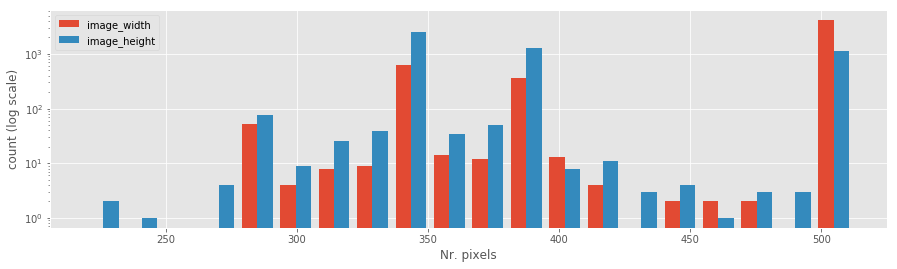

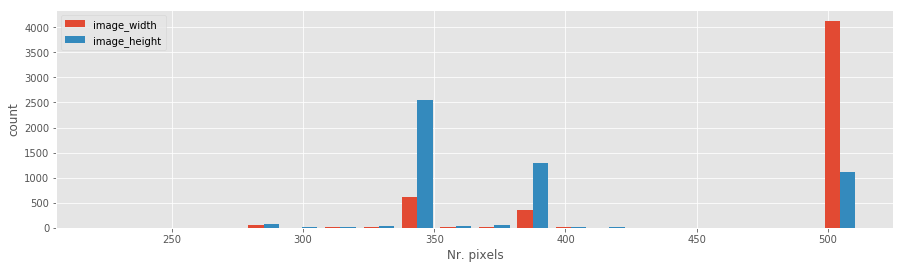

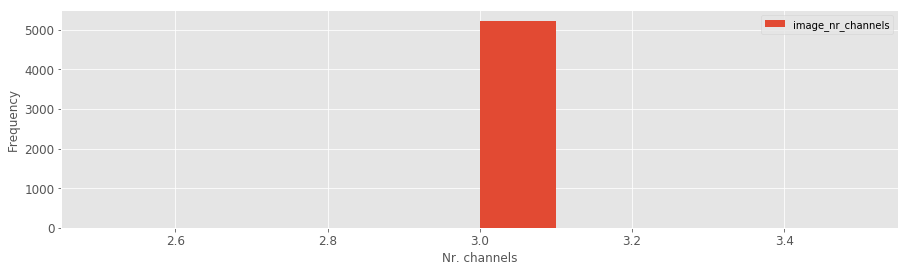

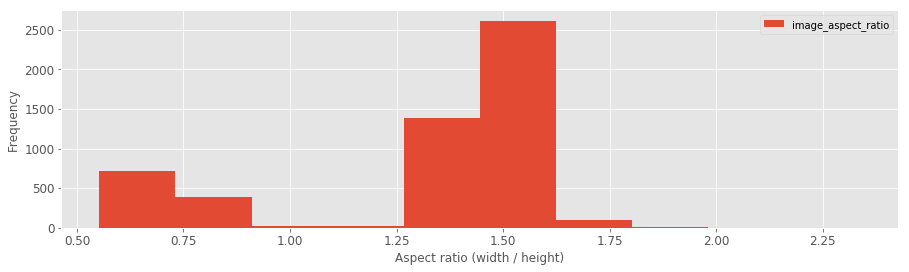

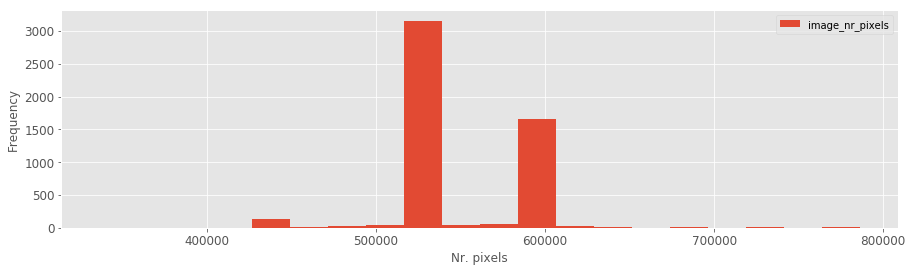

In [11]:
plot_stats(df_iiw_analysis, prefix='image_')

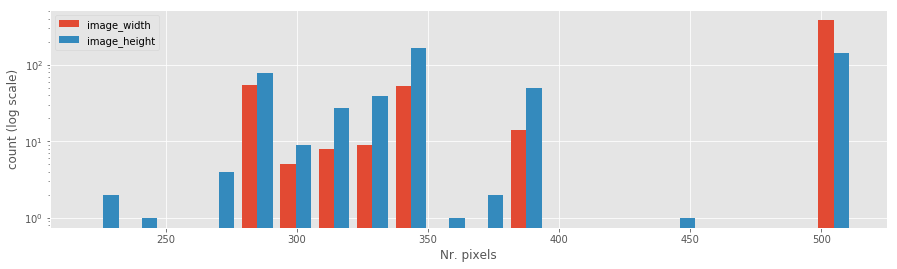

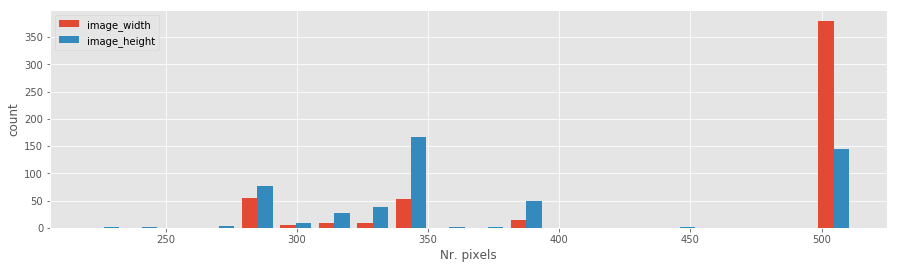

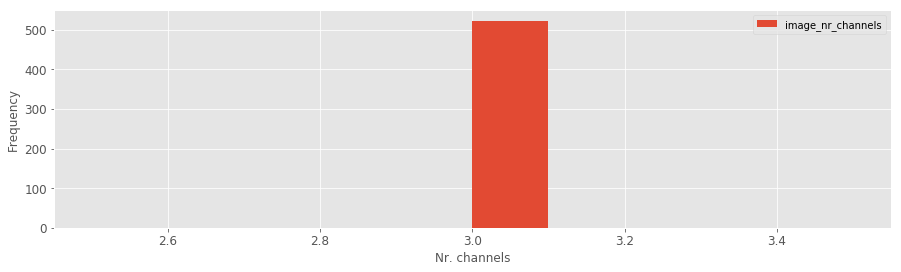

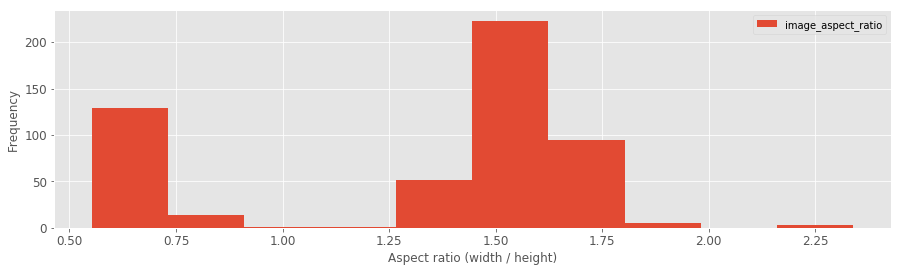

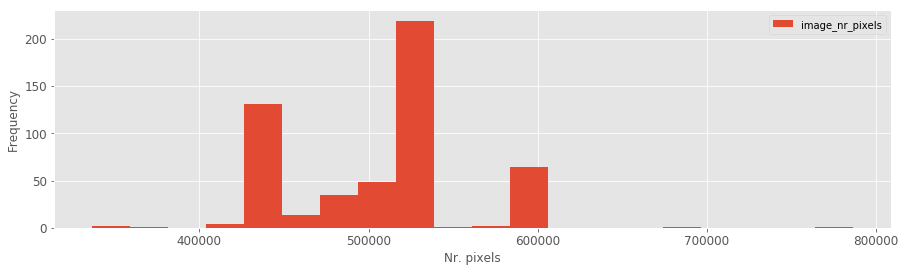

In [15]:
plot_stats(df_iiw_test_analysis, prefix='image_')

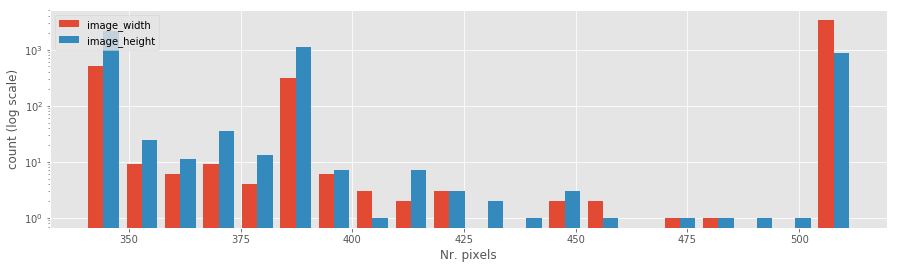

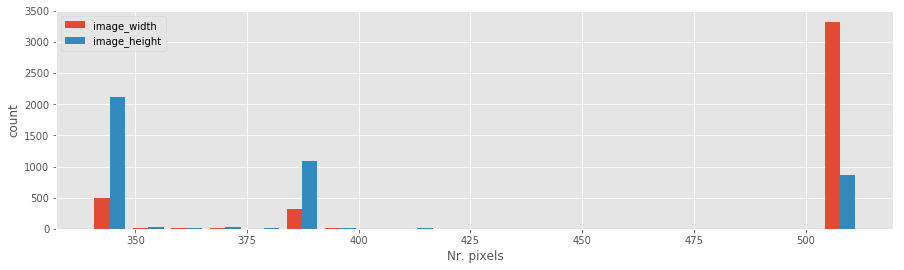

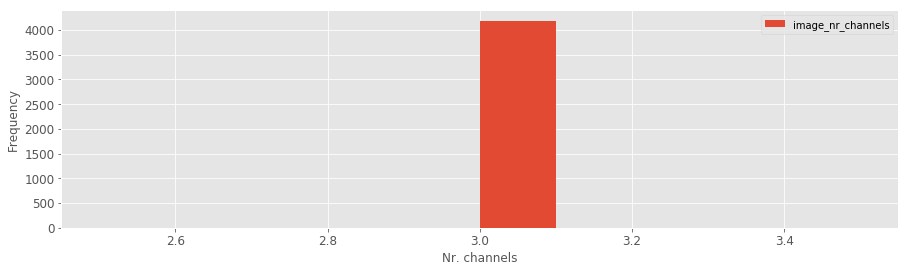

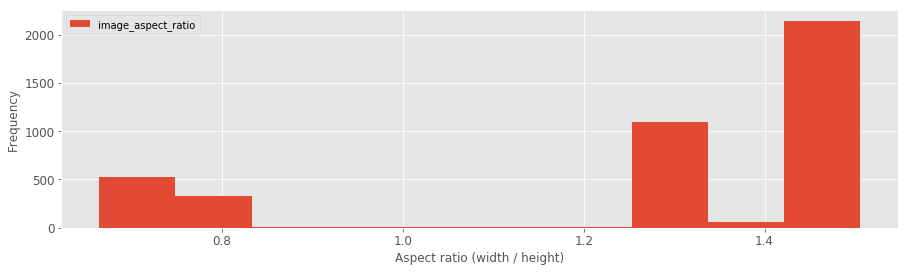

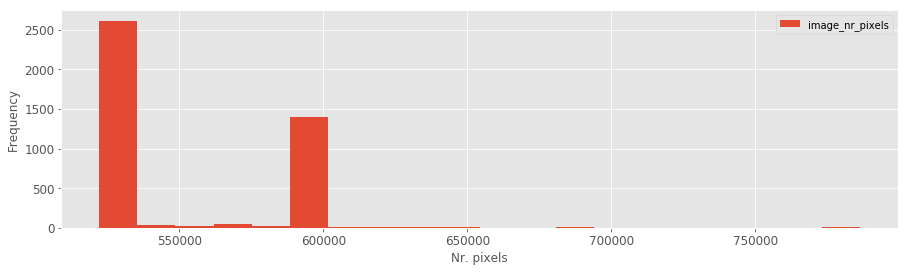

In [16]:
plot_stats(df_iiw_train_analysis, prefix='image_')

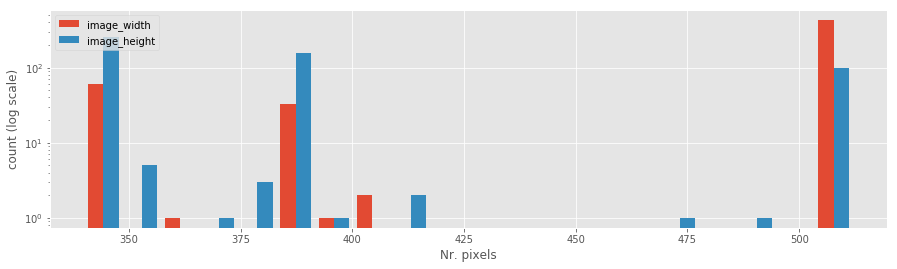

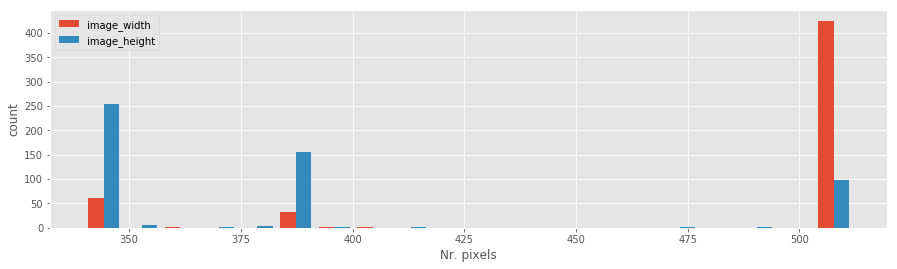

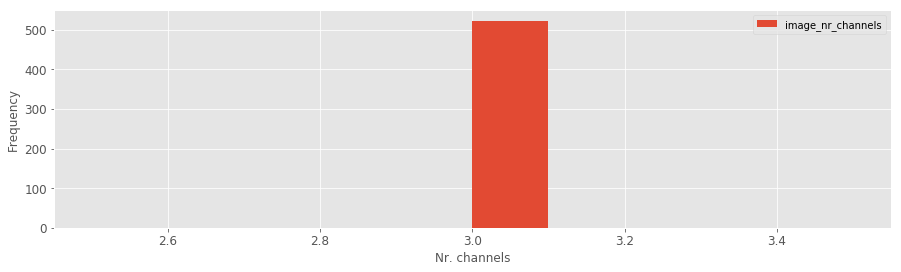

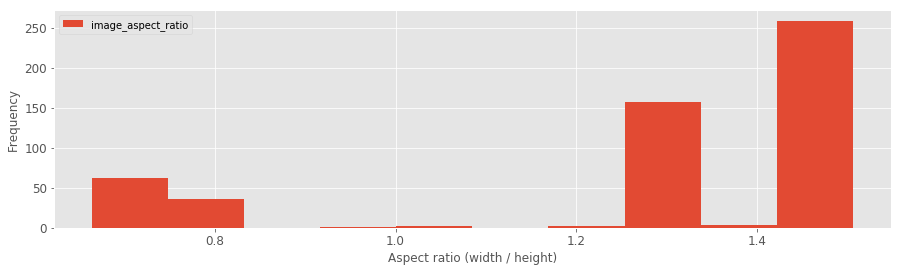

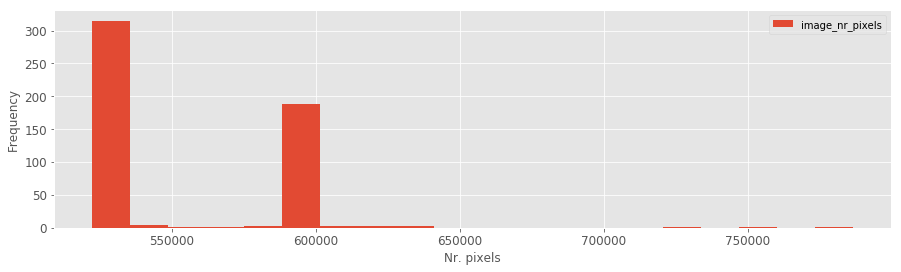

In [17]:
plot_stats(df_iiw_valid_analysis, prefix='image_')

## Analysis of MPI Sintel data set:

In [8]:
df_sintel_analysis = df_images_analysis(df=df_sintel, file_path='image_path', prefix='image_')
df_sintel_analysis = df_images_analysis(df=df_sintel_analysis, file_path='label_path', prefix='label_')

In [9]:
df_sintel_analysis

,,image_path,label_path,image_shape,image_height,image_width,image_nr_channels,image_aspect_ratio,image_nr_pixels,label_shape,label_height,label_width,label_nr_channels,label_aspect_ratio,label_nr_pixels
mpi-sintel-shading/clean_noshadingtextures/alley_1/frame_0001.png,mpi-sintel-shading/albedo_noshadingtextures/alley_1/frame_0001.png,data/mpi-sintel-shading/shading/alley_1/out_01...,data/mpi-sintel-complete/training/invalid/alle...,"(436, 1024, 3)",436,1024,3,2.348624,1339392,"(436, 1024, 1)",436,1024,1,2.348624,446464
mpi-sintel-shading/clean_noshadingtextures/alley_1/frame_0002.png,mpi-sintel-shading/albedo_noshadingtextures/alley_1/frame_0002.png,data/mpi-sintel-shading/shading/alley_1/out_01...,data/mpi-sintel-complete/training/invalid/alle...,"(436, 1024, 3)",436,1024,3,2.348624,1339392,"(436, 1024, 1)",436,1024,1,2.348624,446464
mpi-sintel-shading/clean_noshadingtextures/alley_1/frame_0003.png,mpi-sintel-shading/albedo_noshadingtextures/alley_1/frame_0003.png,data/mpi-sintel-shading/shading/alley_1/out_01...,data/mpi-sintel-complete/training/invalid/alle...,"(436, 1024, 3)",436,1024,3,2.348624,1339392,"(436, 1024, 1)",436,1024,1,2.348624,446464
mpi-sintel-shading/clean_noshadingtextures/alley_1/frame_0004.png,mpi-sintel-shading/albedo_noshadingtextures/alley_1/frame_0004.png,data/mpi-sintel-shading/shading/alley_1/out_01...,data/mpi-sintel-complete/training/invalid/alle...,"(436, 1024, 3)",436,1024,3,2.348624,1339392,"(436, 1024, 1)",436,1024,1,2.348624,446464
mpi-sintel-shading/clean_noshadingtextures/alley_1/frame_0005.png,mpi-sintel-shading/albedo_noshadingtextures/alley_1/frame_0005.png,data/mpi-sintel-shading/shading/alley_1/out_01...,data/mpi-sintel-complete/training/invalid/alle...,"(436, 1024, 3)",436,1024,3,2.348624,1339392,"(436, 1024, 1)",436,1024,1,2.348624,446464
mpi-sintel-shading/clean_noshadingtextures/alley_1/frame_0006.png,mpi-sintel-shading/albedo_noshadingtextures/alley_1/frame_0006.png,data/mpi-sintel-shading/shading/alley_1/out_01...,data/mpi-sintel-complete/training/invalid/alle...,"(436, 1024, 3)",436,1024,3,2.348624,1339392,"(436, 1024, 1)",436,1024,1,2.348624,446464
mpi-sintel-shading/clean_noshadingtextures/alley_1/frame_0007.png,mpi-sintel-shading/albedo_noshadingtextures/alley_1/frame_0007.png,data/mpi-sintel-shading/shading/alley_1/out_01...,data/mpi-sintel-complete/training/invalid/alle...,"(436, 1024, 3)",436,1024,3,2.348624,1339392,"(436, 1024, 1)",436,1024,1,2.348624,446464
mpi-sintel-shading/clean_noshadingtextures/alley_1/frame_0008.png,mpi-sintel-shading/albedo_noshadingtextures/alley_1/frame_0008.png,data/mpi-sintel-shading/shading/alley_1/out_01...,data/mpi-sintel-complete/training/invalid/alle...,"(436, 1024, 3)",436,1024,3,2.348624,1339392,"(436, 1024, 1)",436,1024,1,2.348624,446464
mpi-sintel-shading/clean_noshadingtextures/alley_1/frame_0009.png,mpi-sintel-shading/albedo_noshadingtextures/alley_1/frame_0009.png,data/mpi-sintel-shading/shading/alley_1/out_01...,data/mpi-sintel-complete/training/invalid/alle...,"(436, 1024, 3)",436,1024,3,2.348624,1339392,"(436, 1024, 1)",436,1024,1,2.348624,446464
mpi-sintel-shading/clean_noshadingtextures/alley_1/frame_0010.png,mpi-sintel-shading/albedo_noshadingtextures/alley_1/frame_0010.png,data/mpi-sintel-shading/shading/alley_1/out_01...,data/mpi-sintel-complete/training/invalid/alle...,"(436, 1024, 3)",436,1024,3,2.348624,1339392,"(436, 1024, 1)",436,1024,1,2.348624,446464


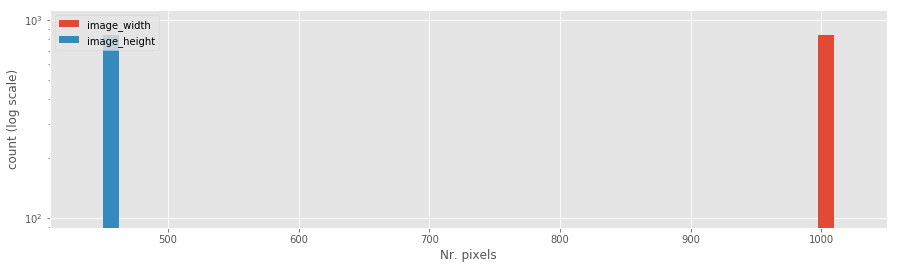

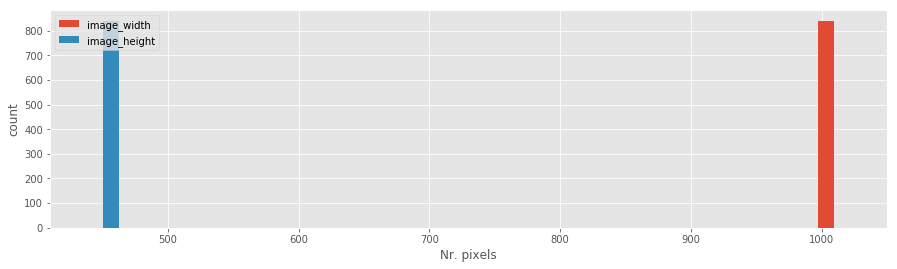

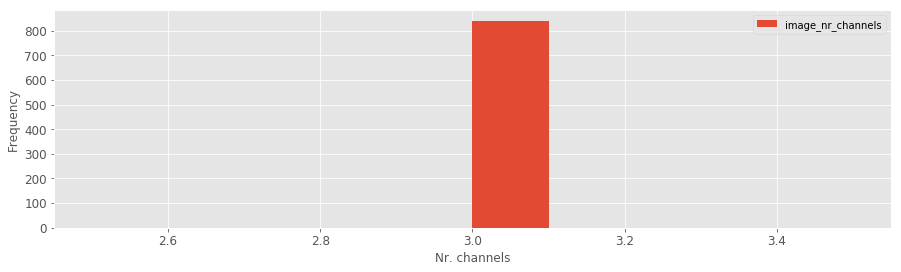

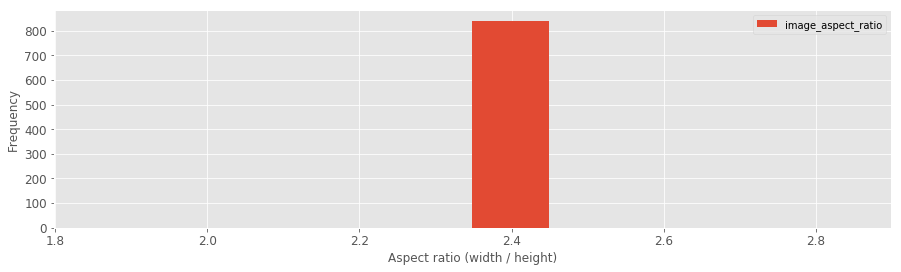

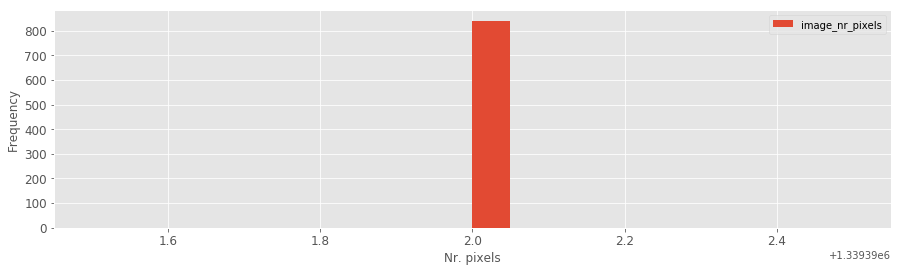

In [10]:
plot_stats(df=df_sintel_analysis, prefix='image_')

In [58]:
plot_stats(df=df_sintel_analysis, prefix='label_')

NameError: name 'df_sintel_analysis' is not defined

In [11]:
df_sintel_test_unknown_analysis = df_images_analysis(df=df_sintel_test_unknown, file_path='image_path', prefix='image_')

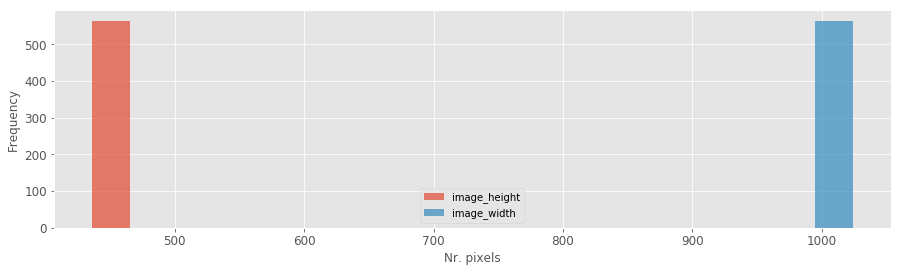

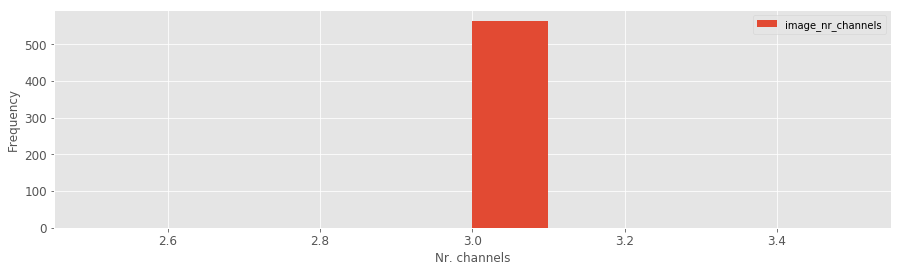

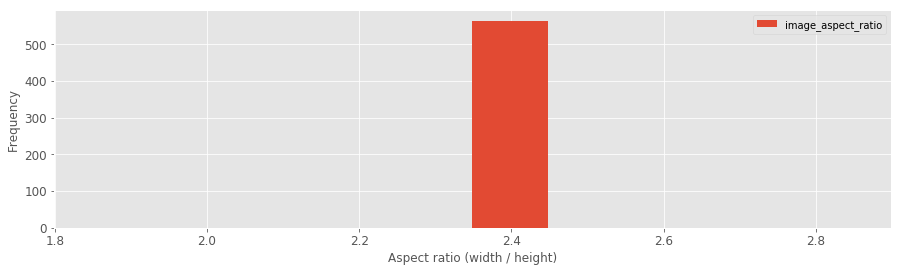

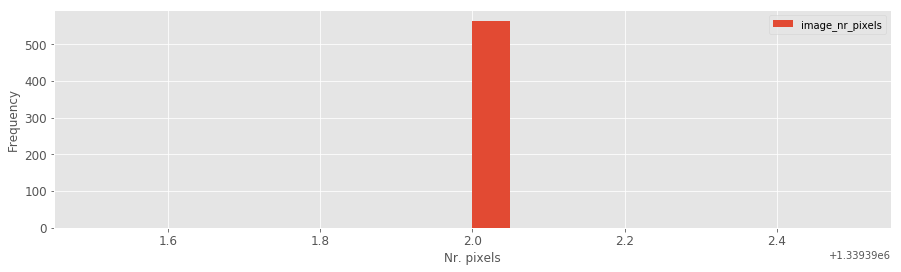

In [12]:
plot_stats(df=df_sintel_test_unknown_analysis, prefix='image_')

## Analysis of MIT data set:

In [13]:
df_mit_analysis = df_images_analysis(df=df_mit, file_path='image_path', prefix='image_')
df_mit_analysis = df_images_analysis(df=df_mit_analysis, file_path='albedo_label_path', prefix='albedo_label_')
df_mit_analysis = df_images_analysis(df=df_mit_analysis, file_path='shading_label_path', prefix='shading_label_')

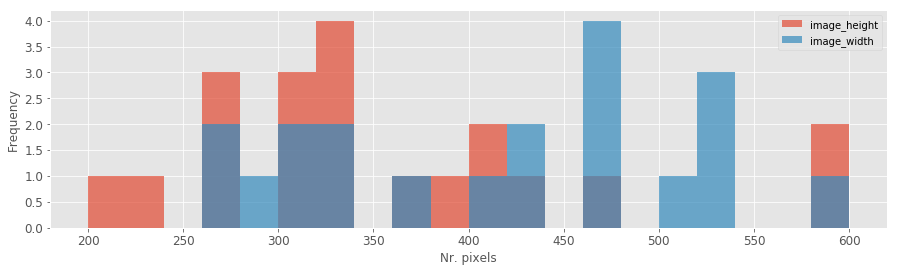

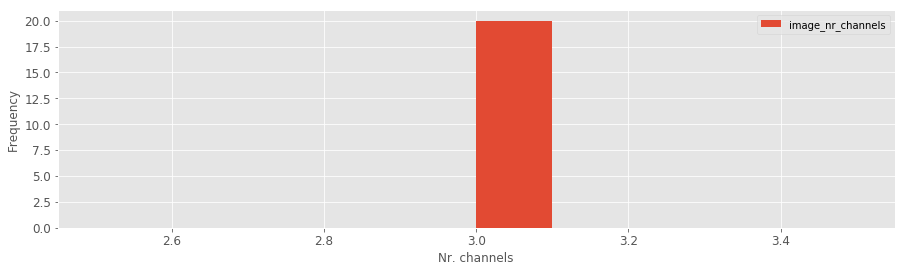

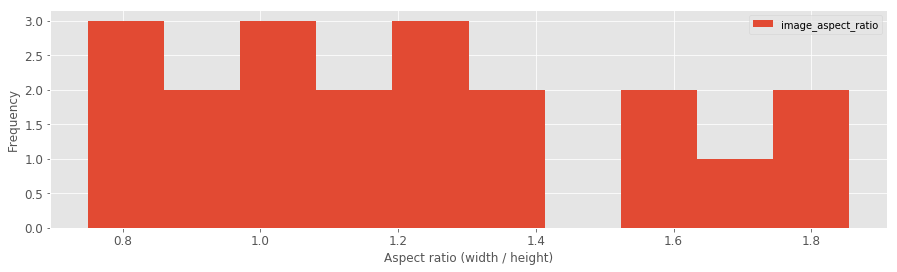

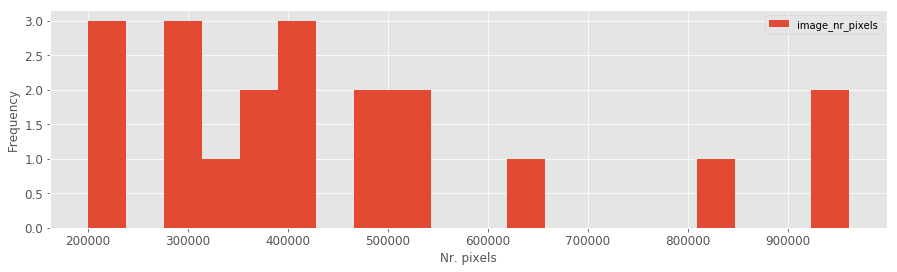

In [14]:
plot_stats(df=df_mit_analysis, prefix='image_')

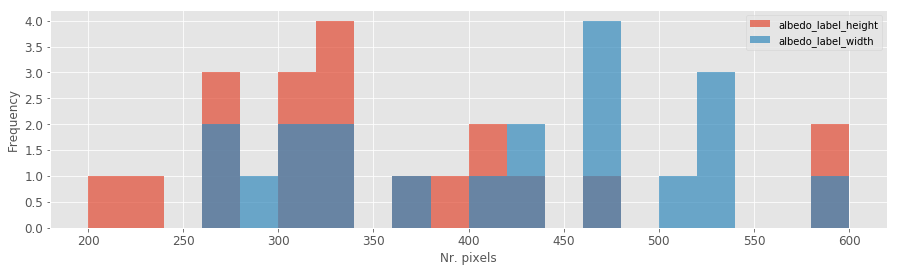

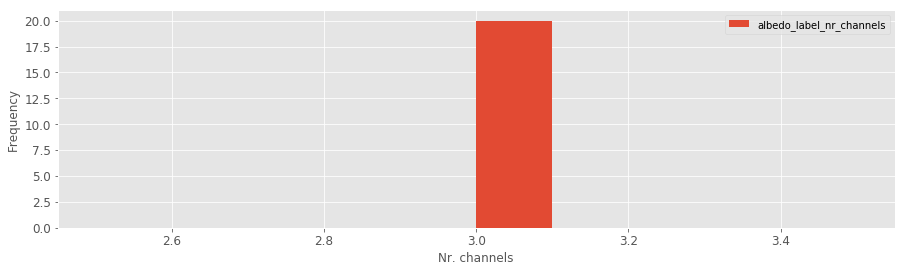

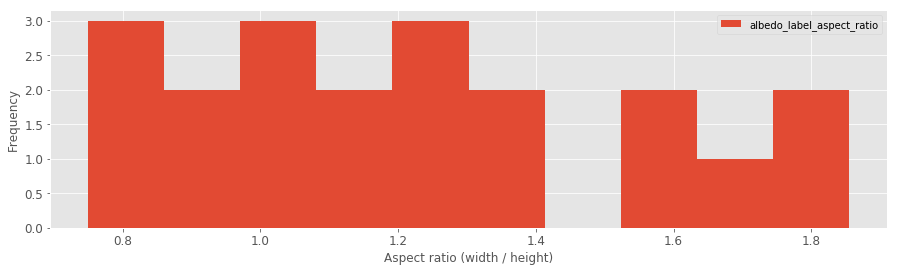

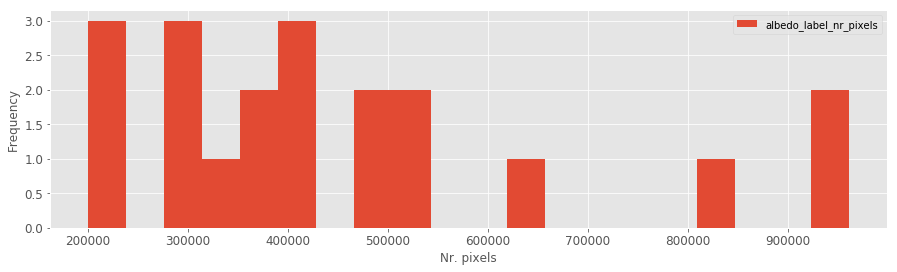

In [15]:
plot_stats(df=df_mit_analysis, prefix='albedo_label_')

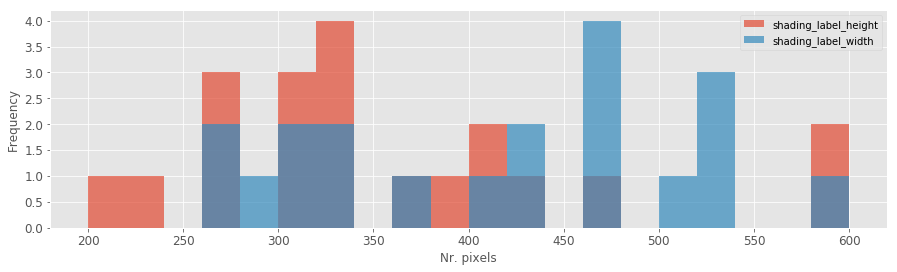

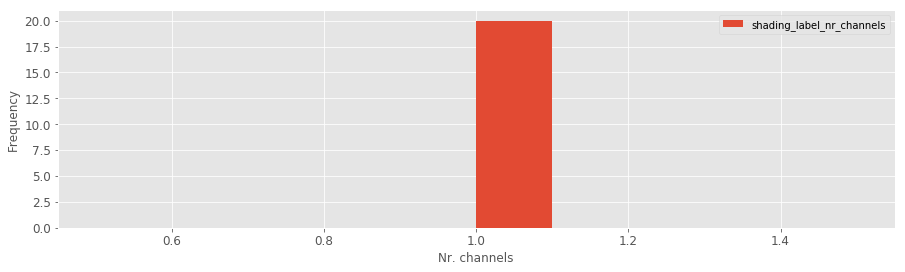

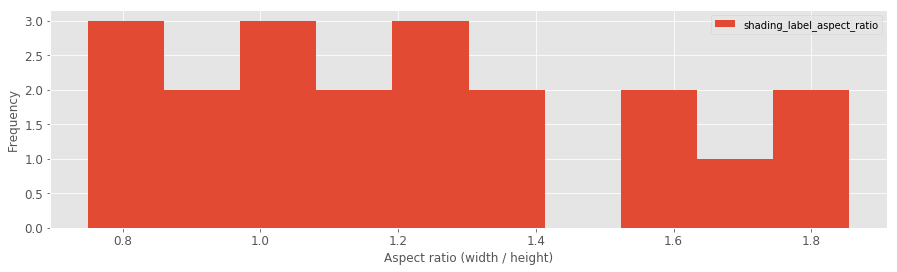

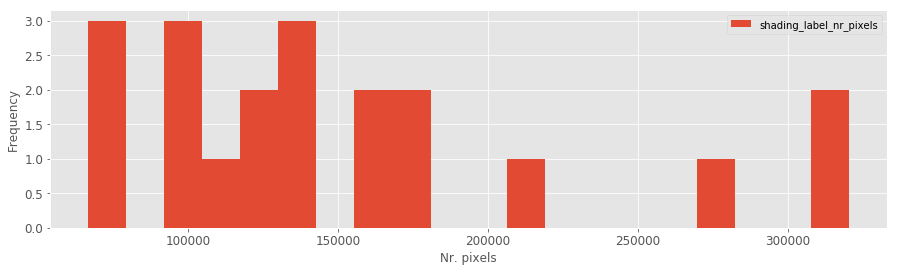

In [16]:
plot_stats(df=df_mit_analysis, prefix='shading_label_')

# Analysis of images

In [10]:
img_sintel = plt.imread(df_sintel.loc[0, 'image_path'])
albedo_sintel = plt.imread(df_sintel.loc[0, 'label_path'])

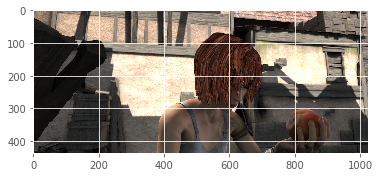

In [11]:
plt.imshow(img_sintel)

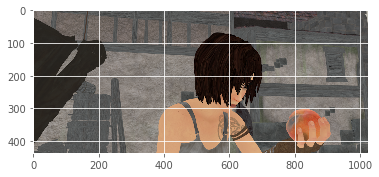

In [12]:
plt.imshow(albedo_sintel)

In [13]:
img_sintel[0, 0] / albedo_sintel[0, 0]

array([ 1.36607146,  1.25242722,  1.132653  ], dtype=float32)

In [14]:
albedo_sintel[0, 0]

array([ 0.43921569,  0.40392157,  0.38431373], dtype=float32)

In [15]:
img_mit = plt.imread(df_mit.loc[0, 'image_path'])
albedo_mit = plt.imread(df_mit.loc[0, 'albedo_label_path'])
shading_mit = plt.imread(df_mit.loc[0, 'shading_label_path'])

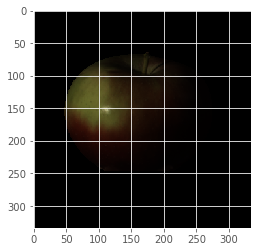

In [16]:
plt.imshow(img_mit)

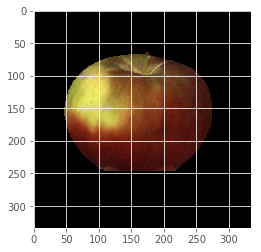

In [17]:
plt.imshow(albedo_mit)

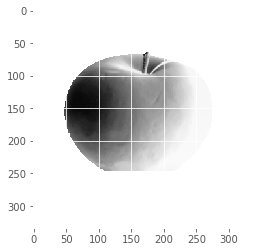

In [64]:
plt.imshow(shading_mit, cmap='Greys')

In [24]:
0.9 / 0.3

3.0

In [23]:
0.3 / 0.9

0.3333333333333333

In [21]:
img_mit[100:150, 100:150]

array([[[ 0.30395973,  0.26320288,  0.12663463],
        [ 0.30923933,  0.26851299,  0.12777905],
        [ 0.29913786,  0.25940338,  0.12437629],
        ..., 
        [ 0.11499199,  0.07635614,  0.04055848],
        [ 0.10635538,  0.06709392,  0.03674373],
        [ 0.10376135,  0.0598764 ,  0.03242542]],

       [[ 0.3129015 ,  0.273579  ,  0.12660411],
        [ 0.31433585,  0.2730602 ,  0.12692454],
        [ 0.30203709,  0.26350805,  0.12327763],
        ..., 
        [ 0.1216907 ,  0.0767834 ,  0.04164187],
        [ 0.12027161,  0.07550164,  0.04454108],
        [ 0.11430533,  0.0696727 ,  0.03939879]],

       [[ 0.31776914,  0.27611199,  0.12793164],
        [ 0.31088731,  0.26851299,  0.12091249],
        [ 0.30428016,  0.26318762,  0.11894408],
        ..., 
        [ 0.11924925,  0.07461662,  0.03797971],
        [ 0.12225528,  0.078233  ,  0.04109254],
        [ 0.11367971,  0.0707866 ,  0.03535515]],

       ..., 
       [[ 0.39148545,  0.3944152 ,  0.16690318],
        

In [20]:
albedo_mit[100:150, 100:150]

array([[[ 0.90780497,  0.76810867,  0.38107881],
        [ 0.91689938,  0.78004122,  0.38783857],
        [ 0.91190964,  0.76432443,  0.37947661],
        ..., 
        [ 0.49620813,  0.31805906,  0.17807278],
        [ 0.4790875 ,  0.28776988,  0.16678111],
        [ 0.46379796,  0.26115817,  0.14566262]],

       [[ 0.91483939,  0.78706032,  0.38545814],
        [ 0.92487985,  0.78815901,  0.38541237],
        [ 0.89684904,  0.77117568,  0.37422752],
        ..., 
        [ 0.50829327,  0.31242847,  0.16929884],
        [ 0.51424432,  0.31206226,  0.18638895],
        [ 0.50225073,  0.29501793,  0.16932936]],

       [[ 0.90875107,  0.78384072,  0.38829634],
        [ 0.89877164,  0.7621271 ,  0.36487374],
        [ 0.88902116,  0.75725949,  0.35715267],
        ..., 
        [ 0.51503778,  0.30746928,  0.15632868],
        [ 0.53110552,  0.32458991,  0.17766079],
        [ 0.49843594,  0.2935378 ,  0.15613031]],

       ..., 
       [[ 0.88039976,  0.86182958,  0.37112993],
        

In [19]:
shading_mit[100:150, 100:150]

array([[ 0.68847179,  0.67862976,  0.66485083, ...,  0.44301519,
         0.43866637,  0.43172351],
       [ 0.6929732 ,  0.6921187 ,  0.6835584 , ...,  0.45780116,
         0.44954604,  0.44599068],
       [ 0.70064849,  0.70102996,  0.70000762, ...,  0.46239415,
         0.45952544,  0.45593956],
       ..., 
       [ 0.84547186,  0.84568548,  0.84438848, ...,  0.58443582,
         0.58695352,  0.57380027],
       [ 0.84895092,  0.85300982,  0.84939343, ...,  0.59230947,
         0.58683145,  0.58478677],
       [ 0.85088885,  0.85032427,  0.84953076, ...,  0.59198904,
         0.59040207,  0.58547342]], dtype=float32)

/Users/udodehm/.venvs/venv_tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


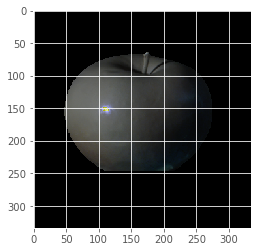

In [41]:
plt.imshow(img_mit / albedo_mit)

In [42]:
shad_test = img_mit / albedo_mit

/Users/udodehm/.venvs/venv_tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [62]:
a = 100
b = 250
print(f'{shad_test[a, b]}')
print(f'true shade = {shading_mit[a, b]}')

[ 0.05237073  0.05921474  0.06593406]
true shade = 0.058167390525341034


In [31]:
img_mit[100, 100]

array([ 0.30395973,  0.26320288,  0.12663463], dtype=float32)